# ELEC-E5510 — Exercise 1: 
## Feature extraction and Modeling the feature distribution

### IMPORTANT: Submit the answers using the provided templates. Do not export the whole notebook!

The goal of this exercise is to get familiar with the feature extraction process used in automatic speech recognition and to learn about the models we typically use to model the feature distributions. 

This notebook first runs through the practical computational steps for producing MFCC features. The code blocks are runnable and you may want to create new code blocks to run your own code. See e.g. [this](https://wiki.python.org/moin/BeginnersGuide/Programmers) if you wish to learn Python, and [this](https://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) for help with Notebooks. 

The notebook also includes the questions to be answered in your submission. Submit your answers in a separate PDF document; don't submit the notebook itself.

First we'll need to import some libraries

In [1]:
import numpy as np
import scipy.signal as signal
from scipy.signal import lfilter
import matplotlib.pyplot as plt

Next, we load the data that we are going to use

In [2]:
sampleword = np.load('sampleword.npy')
M = np.load('M.npy')
D = np.load('D.npy')

## MFCC feature extraction step by step

More information about each step of MFCC: [Mel Frequency Cepstral Coefficient (MFCC) tutorial](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html).

Let's start the exercise by extracting the so-called MFCC features of a sample word. Variable 'sampleword' contains a waveform of a Finnish word 'pyörremyrskyistä' sampled at the rate of 16000Hz. You can plot it by:

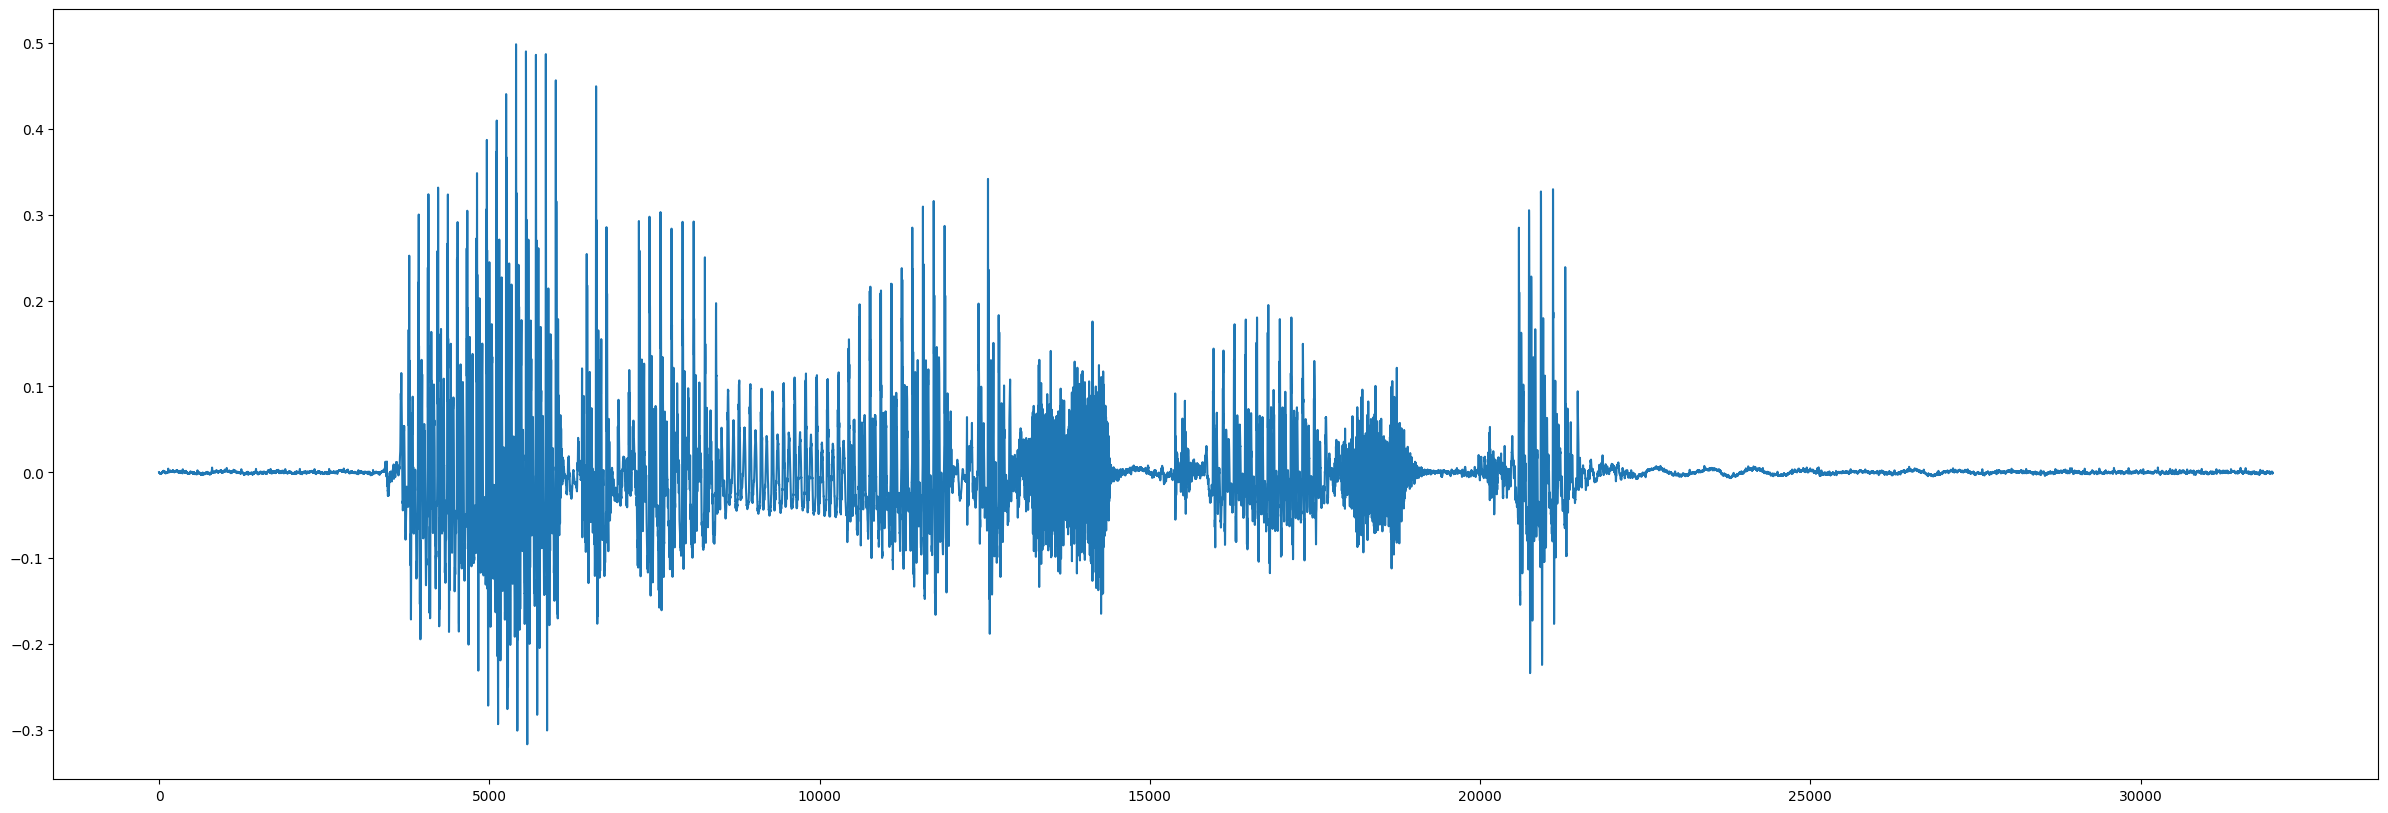

In [3]:
plt.rcParams["figure.figsize"] = (30, 10)
plt.plot(sampleword)

# Step 1: Window Framing, short FFT and the Spectrogram

The first step of the feature extraction is the computation of the short-time Fourier spectrum. With Python:

The fast Fourier transform is a powerful tool that allows us to analyze the frequency content of a signal, but what if our signal’s frequency content varies over time? Such is the case with most audio signals such as music and speech. These signals are known as non periodic signals. We need a way to represent the spectrum of these signals as they vary over time. You may be thinking, “hey, can’t we compute several spectrums by performing FFT on several windowed segments of the signal?” Yes! This is exactly what is done, and it is called the short-time Fourier transform. The FFT is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram.

We need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size

In [35]:
# a helper function for plotting the spectrograms
def plot_spectrogram(spec):
    pho_times = [20, 26, 34, 43, 50, 59, 70, 77, 85, 94, 102, 109, 115, 123, 131]
    pho_labels=['p','y','ö','rr','e','m','y','r','s','k','y','i','s','t','ä']
    plt.title('Spectrogram', fontsize=20)
    plt.xticks(pho_times, pho_labels)
    plt.ylim(0, spec.shape[0])
    plt.ylabel('Frequency (Hz)', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.imshow(spec, cmap='terrain')
    plt.show()

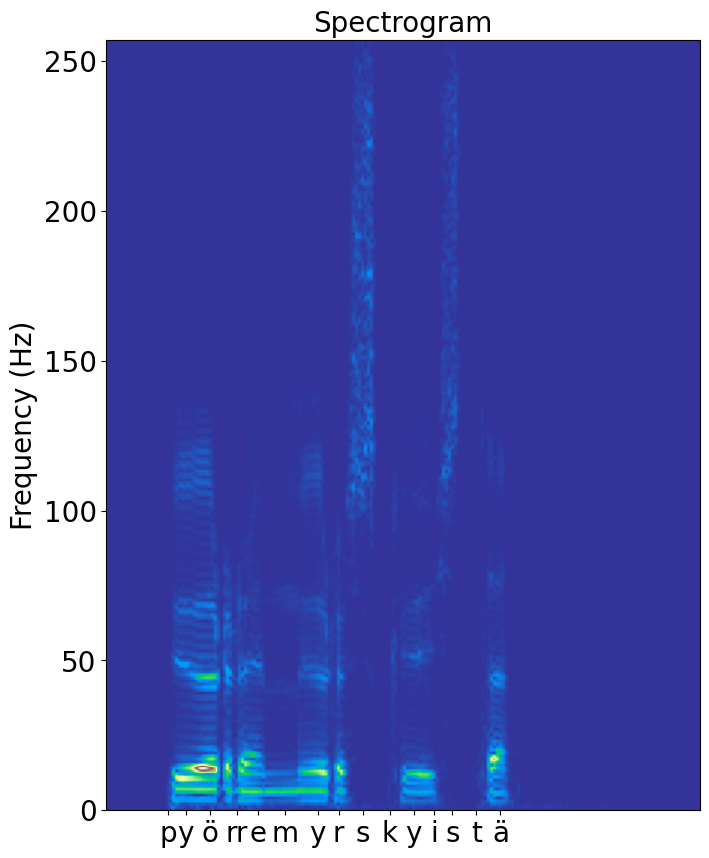

In [36]:
# Size of Hamming window
# Each segment of the signal that the STFT is applied to will be 400 samples long.
window_size = 400 

# Number of points used in the Fast Fourier Transform (FFT)
# Using more points than the window size results in zero-padding, which can give more fine-grained detail in the frequency domain.
nfft = 513 

# number of samples by which adjacent windows/segments overlap. 
# An overlap helps in maintaining continuity between windows and reduces information loss at the boundaries.
noverlap = 240 

# computes the spectrogram of the sampleword signal
# The function returns:
# f: Array of sample frequencies.
# t: Array of segment times.
# s: Spectrogram (complex values).

f, t, s = signal.spectrogram(sampleword, window=signal.hamming(window_size), noverlap=noverlap, nfft=nfft)

# Since s contains complex values (as it represents the magnitude and phase information of the signal in the frequency domain), 
# this line takes the magnitude of the spectrogram and then takes the square root. The square root is applied to compress 
# the dynamic range, making variations in intensity more perceptible.
s = np.sqrt(np.abs(s))
plot_spectrogram(s)

This extracts the short-time Fourier spectrum of the sample word, using 25ms Hamming window, and displays it.

It is advisable to apply a high-pass filter to the waveform before taking the spectrum. You can compare the results with and without the filter:

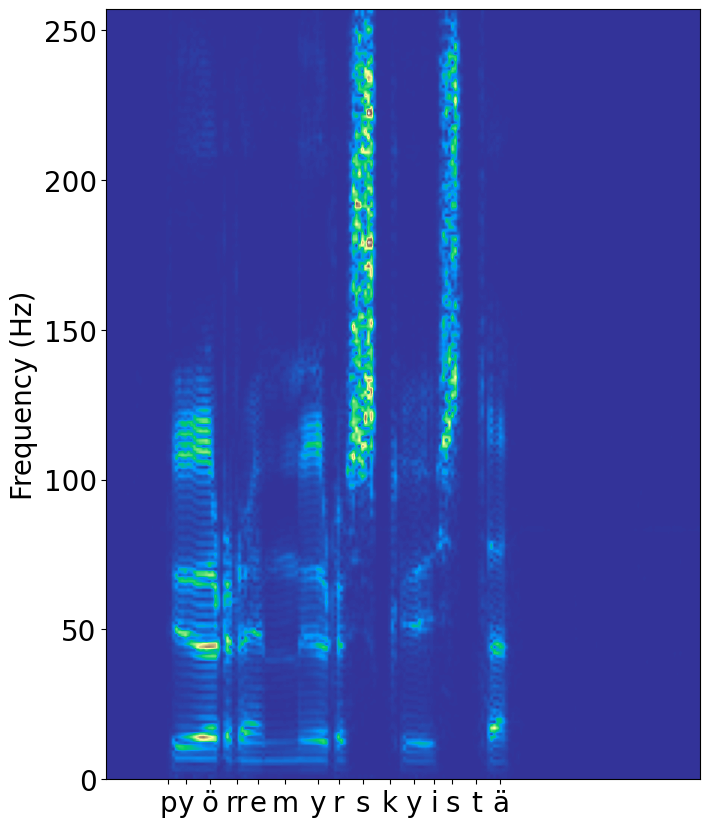

In [6]:
window_size = 400
nfft = 513
noverlap = 240

f, t, s2 = signal.spectrogram(lfilter([1, -0.97], 1, sampleword), window=signal.hamming(window_size), noverlap=noverlap, nfft=nfft)
s2 = np.sqrt(np.abs(s2))

plot_spectrogram(s2)

You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. There are some additional details going on behind the scenes when computing the spectrogram. The y-axis can be converted to a log scale, and the color dimension is converted to decibels (you can think of this as the log scale of the amplitude). This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.

# Step 2: The Mel Scale and Mel transformation

Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same.

In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.

The Mel scale formula as a function of frequency (Hz) is:

$$m = 2595 \log_{10}(1 + \frac{f}{700})$$

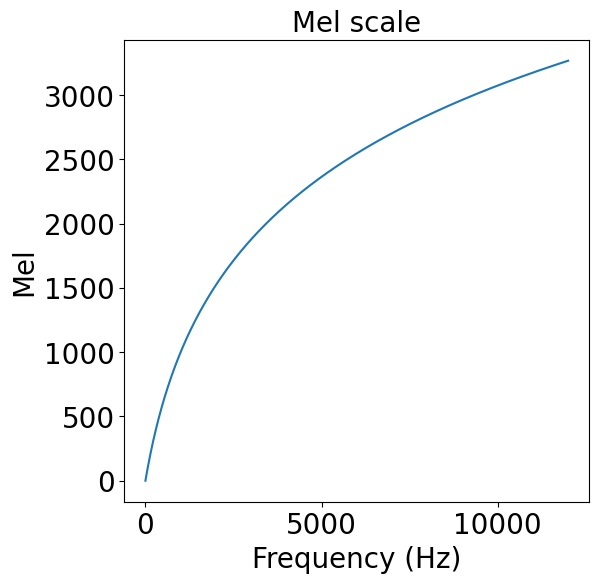

In [40]:
# Plotting the Mel scale on Frequency of range [0, 12000]

frequency = np.linspace(0, 12000, 12000)
mel = 2595 * np.log10(1 + frequency / 700)
plt.figure(figsize=(6, 6))
plt.title('Mel scale', fontsize=20)
plt.plot(frequency, mel)
plt.ylabel('Mel', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.tick_params(labelsize=20)

Continue with the filtered version of the spectrum. The next phase is to apply a non-linear frequency transformation. The variable M contains a matrix that applied to the spectrum computes the so-called mel-spectrum. You can visualize the triangular filters in M:

(0.0, 0.321468)

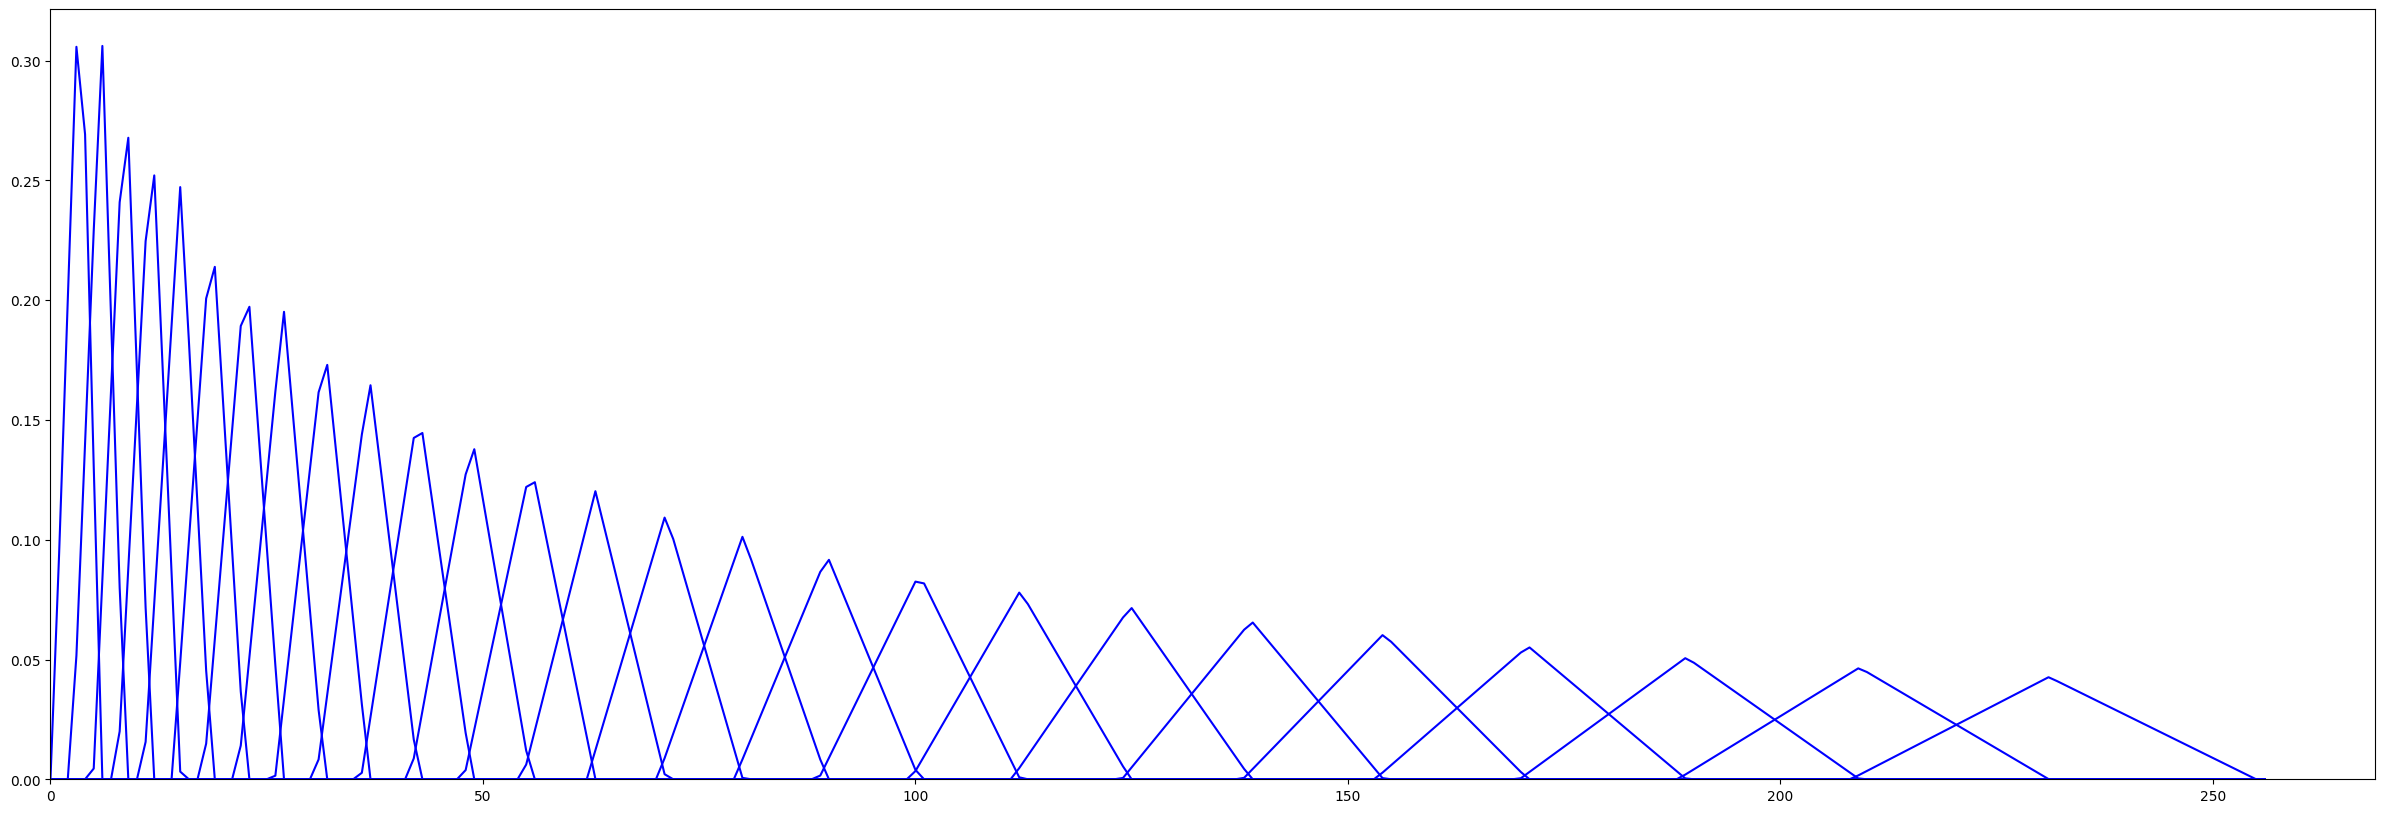

In [7]:
plt.plot(M.T, color='blue')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

The mel-scale transformation involves applying a set of triangular filters to the spectrum of the audio signal. These triangular filters are spaced linearly at low frequencies and logarithmically at high frequencies, reflecting the human ear's sensitivity.

The matrix M contains a set of triangular filters, each represented by a row in the matrix. When you apply M to the spectrum of an audio signal, you are essentially calculating the dot product between each row of M (each triangular filter) and the spectrum. The result is the mel-spectrum, which is a compressed version of the original spectrum that highlights the frequencies most important for human perception.

After the mel-transformation a logarithm is taken of the frequency bin energies to compress the energy values. Visualize the resulting logarithmic mel-spectrum:

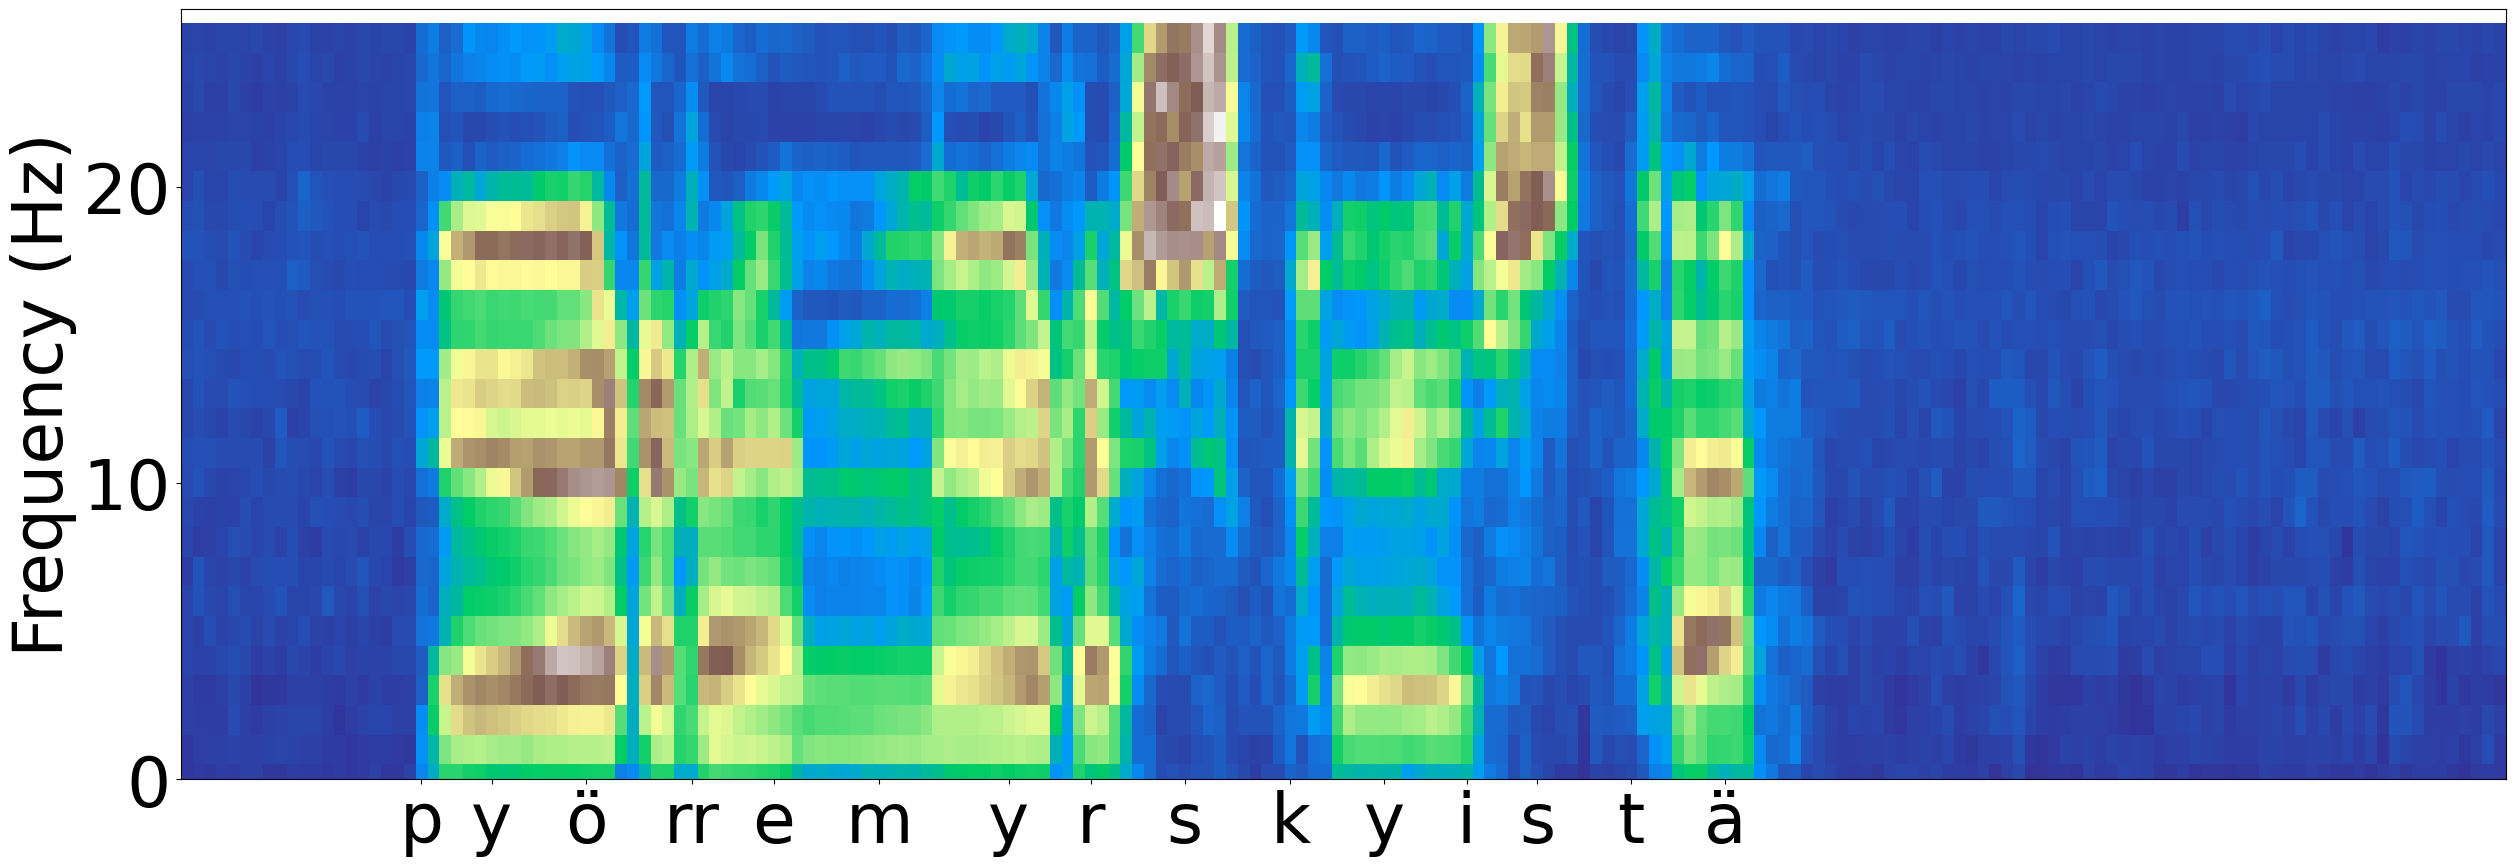

In [41]:
pho_times = [20, 26, 34, 43, 50, 59, 70, 77, 85, 94, 102, 109, 115, 123, 131]
pho_labels=['p','y','ö','rr','e','m','y','r','s','k','y','i','s','t','ä']
plt.xticks(pho_times, pho_labels)
plt.ylim(0, M.shape[0])
plt.ylabel('Frequency (Hz)', fontsize=50)
plt.tick_params(labelsize=50)

Mel_transformed_spectrum = M.dot(np.sqrt(np.abs(s2))) + 1
Log_Mel_transformed_spectrum = np.log(Mel_transformed_spectrum)
plt.imshow(Log_Mel_transformed_spectrum, aspect='auto', cmap='terrain')

# Step 3: Decorrelation by Discrete Cosine Transform (DCT)

Filter bank coefficients are the result of applying a series of filters, typically arranged in a bank, to a signal in order to analyze or extract certain features from the signal. These filters are designed to pass specific frequency bands while attenuating others, allowing for a detailed analysis of the signal’s frequency content. In this context, the filter bank coefficients are the Mel triangular filters.

It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; num_ceps = 12. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

The Discrete Cosine Transform (DCT) is a mathematical transformation used to convert a signal or image from its original domain (often time or space) into a representation in the frequency domain. 

Intuition:

- Energy Compaction: One of the key properties of the DCT is its ability to compact the energy of a signal into a smaller number of coefficients, especially when the signal has a lot of redundancy or similarity across its values. This is particularly useful in compression applications.

- Decorrelation: The DCT helps in transforming the signal in such a way that the resulting coefficients are less correlated with each other, which is beneficial for various processing tasks.

- Cosine Waves: The DCT represents a signal as a sum of cosine waves with different frequencies and amplitudes. The coefficients of the DCT tell us how much of each cosine wave is present in the original signal.


The last phase is to decorrelate the features and reduce the dimension. This is done using the discrete cosine transformation (DCT). A variable D contains the required matrix, you can again visualize it as with matrix M or plotting the matrix with:

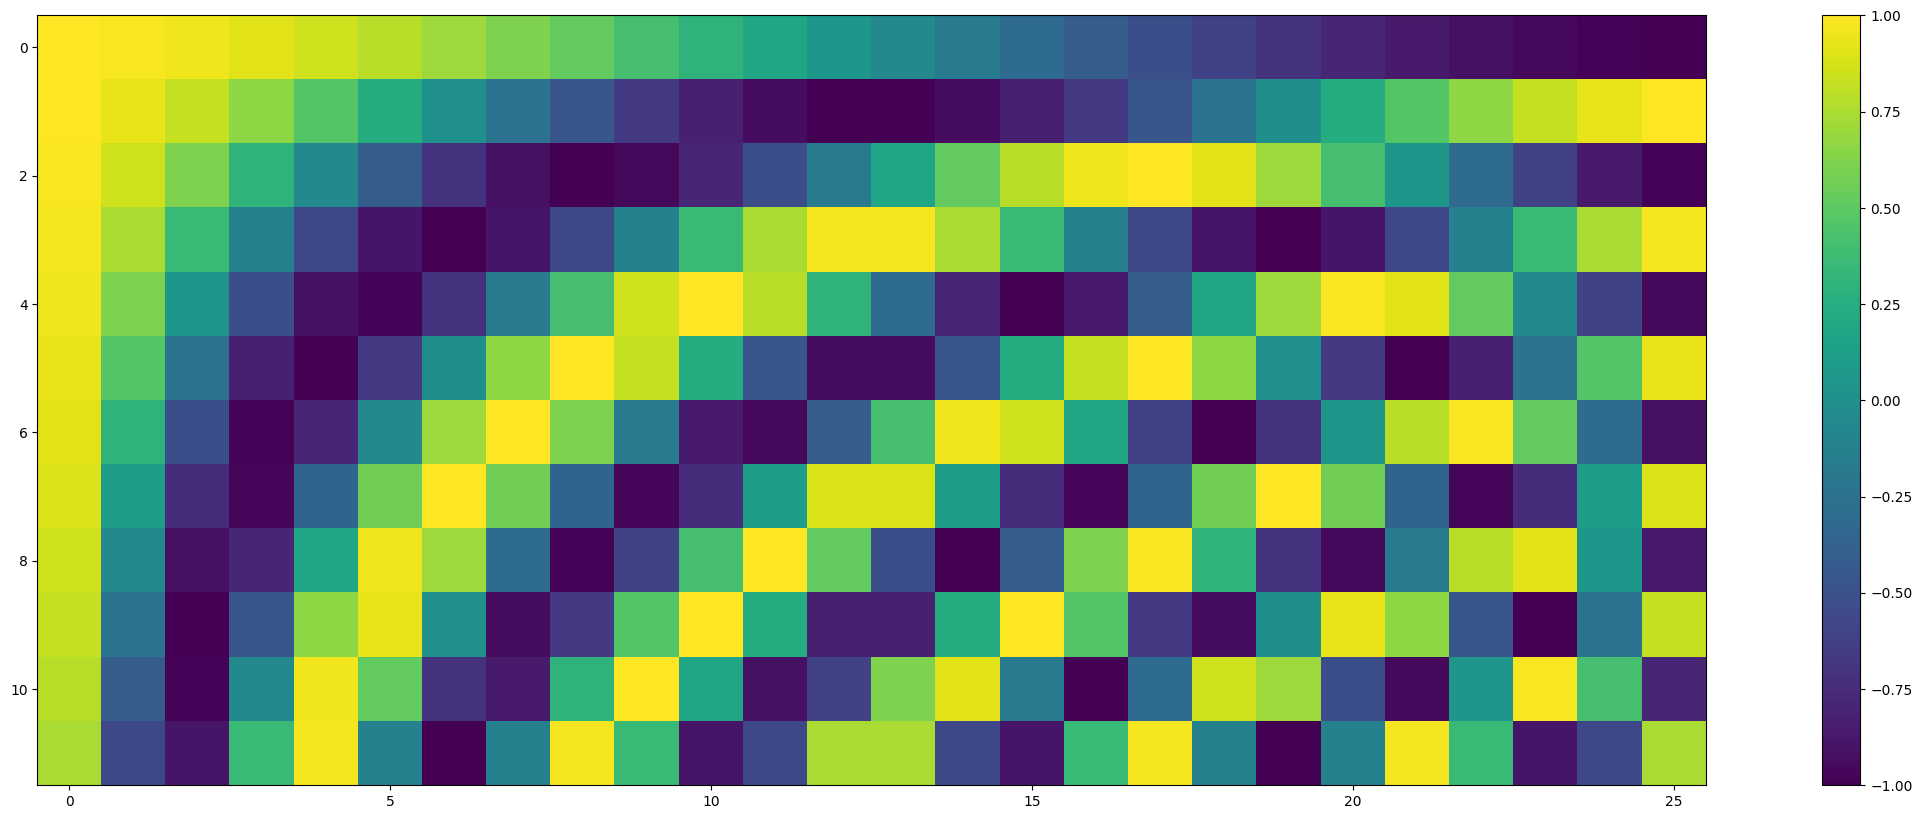

In [9]:
plt.imshow(D)
plt.colorbar()

The final features are obtained simply by:

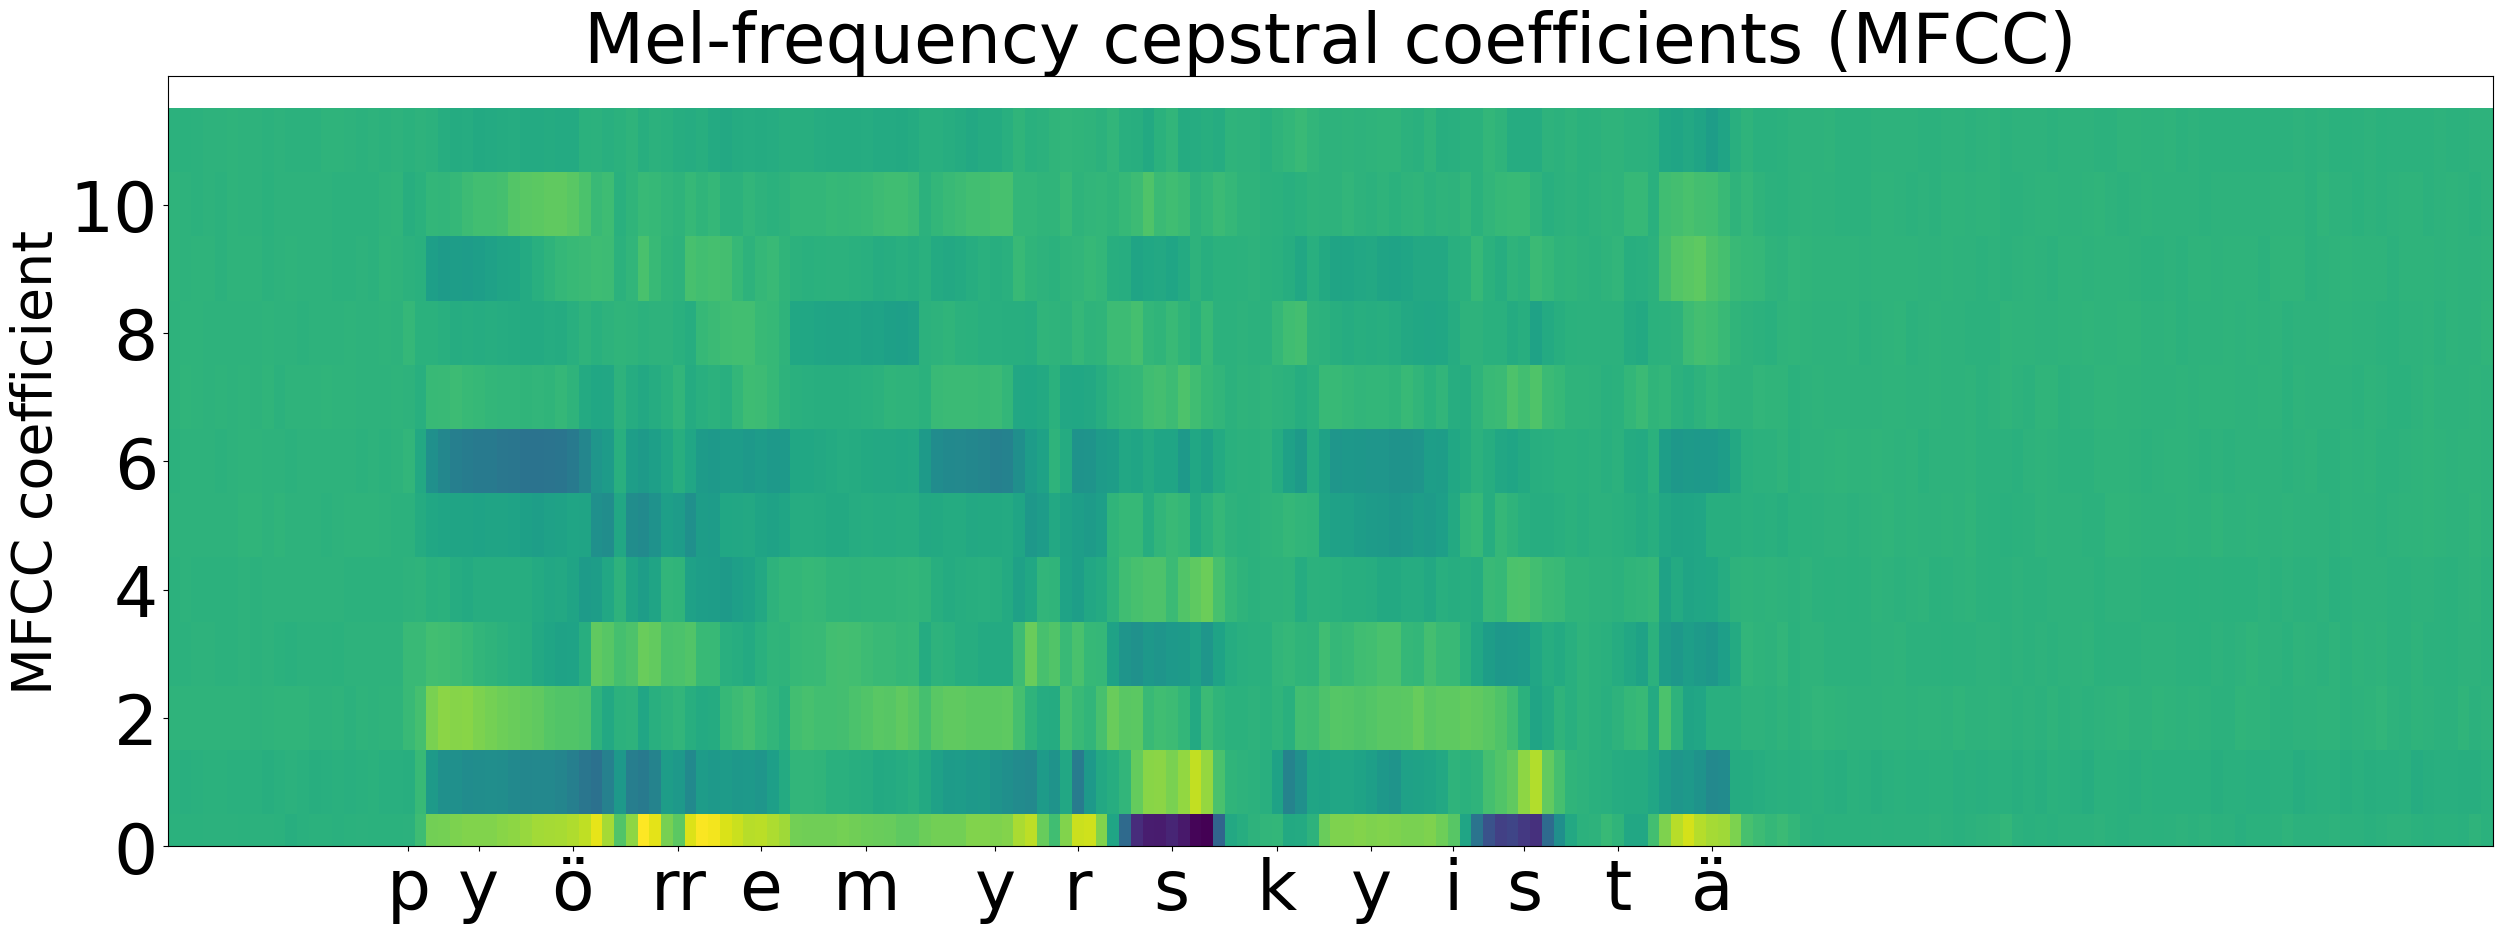

In [44]:
pho_times = [20, 26, 34, 43, 50, 59, 70, 77, 85, 94, 102, 109, 115, 123, 131]
pho_labels=['p','y','ö','rr','e','m','y','r','s','k','y','i','s','t','ä']
plt.title("Mel-frequency cepstral coefficients (MFCC)", fontsize=50)
plt.xticks(pho_times, pho_labels)
plt.ylim(0, D.shape[0])
plt.yticks(np.arange(0, 12, step=2))
plt.ylabel('MFCC coefficient', fontsize=40)
plt.tick_params(labelsize=50)

Mel_transformed_spectrum = M.dot(np.sqrt(np.abs(s2))) + 1
Log_Mel_transformed_spectrum = np.log(Mel_transformed_spectrum)
Decorrelated_Log_Mel_transformed_spectrum = D.dot(Log_Mel_transformed_spectrum) # Known as Mel-frequency cepstral coefficients (MFCC)

plt.imshow(Decorrelated_Log_Mel_transformed_spectrum, aspect='auto')

The final features are called Mel-frequency cepstral coefficients or MFCCs.

### Question 1:

a. What are the properties of MFCC features that make them well suited for automatic speech recognition?

b. Why wouldn't spectrogram or mel-spectrum features work so well?

## Gaussian mixture models

Gaussian mixture models (GMMs) are a very common feature distribution model in speech recognition. GMMs are flexible, general-purpose models. One of the big advantages of GMMs is having an effective estimation algorithm. Most often GMMs are estimated using the Expectation-Maximization (EM) algorithm. It is an iterative algorithm that, starting from an initial model, improves the model such that the likelihood of the model is guaranteed not to decrease at any iteration. The drawbacks of the algorithm are that the number of mixture components must be known beforehand and that in general only a local maximum of the likelihood is found. But in practice, using some heuristics and a good initialization, the EM algorithm works very well. Furthermore, the GMM estimation algorithm integrates very well into the hidden Markov model estimation algorithm, which is important in speech recognition, and which we will see later in the course.

If you are interested, you can learn more about the EM algorithm from this Gentle Tutorial of the EM algorithm [Gentle Tutorial of the EM algorithm](https://people.ece.uw.edu/bilmes/p/pgs/index.html)

In [11]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from scipy.stats import mode, multivariate_normal

![image](ASR_Step.png)

Gaussian Mixture Models (GMMs) are closely related to Automatic Speech Recognition (ASR), serving as a crucial component in many traditional ASR systems. Here’s an overview of how they are related:

1. Modeling Acoustic Features:
- Feature Representation: In ASR, audio signals are converted into a sequence of feature vectors, often using techniques like Mel-Frequency Cepstral Coefficients (MFCCs).
- GMMs for Acoustic Modeling: GMMs are used to model the distribution of these acoustic features for different phonemes or sound units in a language.

2. Handling Variability in Speech:
- Capturing Diversity: Speech signals exhibit a lot of variability due to differences in speaker characteristics, accents, and recording conditions. GMMs, with their ability to represent complex distributions, can capture this diversity in the acoustic feature space.
- Mixture Components: The different components of a GMM can model different modes of the distribution, accounting for variations in how a particular phoneme might be pronounced.

3. Likelihood Estimation:
- Computing Probabilities: Given an acoustic observation (feature vector), a GMM can provide the likelihood of that observation being generated by a particular phoneme model.
- Use in ASR Decoding: These likelihoods are crucial for the ASR decoder, which aims to find the most probable word or sentence given the sequence of acoustic observations.

4. Integration with Hidden Markov Models (HMMs):
- From Phonemes to Words: GMMs are often used in conjunction with Hidden Markov Models (HMMs) in ASR. HMMs provide a temporal model, modeling the sequence of sounds over time, while GMMs model the distribution of acoustic features for each state in the HMM.
- Complete ASR System: Together, GMMs and HMMs form a powerful combination for modeling the complex relationship between acoustic signals and phonetic units, and subsequently, words and sentences.

5. Training and Adaptation:
- EM Algorithm: GMM parameters are typically estimated using the Expectation-Maximization (EM) algorithm, which iteratively improves the model to better fit the training data.
- Adaptability: GMMs can also be adapted to new speakers or acoustic conditions, helping to improve ASR performance in diverse settings.

The training data for the GMMs contains a maximum of 3000 samples for each class, which are 17 most common Finnish phonemes. The samples have been taken from a database of 50 male speakers. There is no time structure in the training data samples, the samples have been taken from random positions of the phones. The class numbers of the training data are in variable `train_class` and the phoneme labels corresponding to the class numbers are in `phonemes`.

In [49]:
train_data = np.load('train_data.npy')
train_class = np.load('train_class.npy')
test_data = np.load('test_data.npy')
test_class = np.load('test_class.npy')

# Variables `tw1`, `tw2` and `tw3` contain the feature representations of three Finnish words. 

tw1 = np.load('tw1.npy') 
tw2 = np.load('tw2.npy')
tw3 = np.load('tw3.npy')

phonemes = 'aehijklmnoprstuvy'

print("train_data.shape: ", train_data.shape)
print("train_class.shape: ", train_class.shape)

print("test_data.shape: ", test_data.shape)
print("test_class.shape: ", test_class.shape)

print("Number of classes: ", len(np.unique(train_class)))

train_data.shape:  (46489, 26)
train_class.shape:  (46489,)
test_data.shape:  (4527, 26)
test_class.shape:  (4527,)
Number of classes:  17


In [50]:
def plot_confusion(C, phonemes):
    C = C / C.sum(axis=1)[:, np.newaxis]
    labels = [p for p in phonemes]
    df_cm = pd.DataFrame(C, index=labels, columns=labels)
    fig = sns.heatmap(df_cm, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tick_params(labelsize=20)
    plt.show(fig)

If the training data consists of 17 different classes (e.g., phonemes in the context of speech recognition), and you are training a separate Gaussian Mixture Model (GMM) for each class, then you would end up with 17 different GMM models.

Each of these models is trained specifically on the data belonging to its respective class, allowing it to capture the distribution of features associated with that class. When a new observation needs to be classified, you can use these models to calculate the likelihood of the observation given each class, and then use these likelihoods to make a classification decision.

However, number of GMM can vary based on the n_components

In [51]:
import numpy as np
from sklearn.mixture import GaussianMixture

def train_gmm(train_data, train_class, n_components):
    # K: Number of unique classes (phonemes) in the training data = 17
    K = len(np.unique(train_class))
    
    # Initializing lists to store parameters for each class
    mu = []  # Means of the Gaussian components
    sigma = []  # Covariances of the Gaussian components
    weight = []  # Weights of the Gaussian components
    prior = []  # Prior probabilities of each class
    model = []  # Trained GMM models for each class

    # Looping through each class to train a separate GMM
    for k in range(K):
        # Creating a Gaussian Mixture Model with specified number of components
        # 'diag' means diagonal covariance matrix, which assumes independence between features
        gmm = GaussianMixture(n_components, 
                              covariance_type='diag', 
                              max_iter=500, 
                              random_state=0)
        
        # Extracting samples belonging to the current class
        cvals = train_data[train_class == k]
        # Calculating the number of samples in the current class
        N = cvals.shape[0]

        # Fitting the GMM to the data of the current class using Expectation Maximization (EM) algorithm
        gmm.fit(cvals)
        
        # Appending the GMM parameters to the lists
        mu.append(gmm.means_)
        sigma.append(gmm.covariances_)
        weight.append(gmm.weights_)  
        # Calculating and appending the prior probability of the current class
        prior.append(N / train_data.shape[0])
        # Appending the trained GMM model
        model.append(gmm)
    
    # Creating a dictionary to store all the GMM parameters and models
    bayesS = {'mu': np.array(mu), 'sigma': np.array(sigma), 'prior': prior, 'weight': np.array(weight), 'model': model}
    
    return bayesS


In [15]:
# normalize the data
z = StandardScaler()
train_data_normalized = z.fit_transform(train_data)
test_data_normalized = z.transform(test_data)
tw1_normalized = z.transform(tw1)
tw2_normalized = z.transform(tw2)
tw3_normalized = z.transform(tw3)

Using the `train_gmm` function, train a GMM by running the cell below:

In [16]:
n_components = 25
S = train_gmm(train_data_normalized, train_class, n_components)

The variable `n_components` is the number of mixture components for each class. The command returns a structure S that contains all the necessary information about the Gaussian mixture models. Here, the mixture components are 26-dimensional and the covariances of the mixture components have been restricted to be diagonal.

In [17]:
def predict(train_data, S, n_components):
    N = train_data.shape[0]
    K = S['sigma'].shape[0]
    mu_ = S['mu']
    sigma_ = S['sigma']
    prior_ = S['prior']
    weight_ = S['weight']
    model_ = S['model']
    pdf = np.zeros((N, K))

    for k in range(K):
        weight = weight_[k]
        mu = mu_[k]
        sigma = sigma_[k]
        prior = prior_[k]
        model = model_[k]
        
        likelihood = np.exp(model.score_samples(train_data))
        pdf[:, k] = prior * likelihood.reshape(-1, 1).ravel()
    
    predictions = np.argmax(pdf, axis=1)
    return predictions

The newly trained GMM can be used for recognition by chaining the computation of density functions and decision processes:

In [53]:
predictions = predict(train_data_normalized, S, n_components)
print(predictions)
print("Predictions.shape: ", predictions.shape)

[ 9 13  9 ... 16 16 16]
Predictions.shape:  (46489,)


`predictions` contains now the recognized class numbers of the training data. It is a large vector, to view a part of it decoded with the phoneme labels, type e.g.:

In [19]:
subsample_predictions = predictions[2991:3010]
predicted_phonemes = [phonemes[x] for x in subsample_predictions]
print(''.join(predicted_phonemes))

aaoahkaaaeeeeeheeie


This shows the recognition results of 10 samples of /a/ and 10 samples of /e/ phones.

Lastly, you can compute the error percentage of the recognition by comparing the result to the reference class numbers:

In [20]:
predictions = predict(train_data_normalized, S, n_components)
print(accuracy_score(predictions, train_class) * 100)

68.80767493385532


### Question 2:

Variables `test_data` and `test_class` contain the same kind of data as the training data but independent of the training data. In this case it was obtained from different speakers than the training data. Using the training data, train phoneme models with [5, 10, 15, 20, 25, 30, 35] components and evaluate their performance with both the training set and the independent test set.

<b>Plot</b> the error rates of both the train and the test sets with <b>respect to the number of components in GMMs.</b>

<b>Answer the following questions:</b>

a. Why are the recognition results with the train and the test set different?

b. What is a good number of components for recognizing an unknown set of samples?

In [55]:
# Variables `test_data` and `test_class` contain the same kind of data as the training data but independent of the training data. In this case it was obtained from different speakers than the training data. Using the training data, train phoneme models with [5, 10, 15, 20, 25, 30, 35] components and evaluate their performance with both the training set and the independent test set.

# <b>Plot</b> the error rates of both the train and the test sets with <b>respect to the number of components in GMMs.</b>

n_components_list = [5, 10, 15, 20, 25, 30, 35]
train_error_rates = []
test_error_rates = []

for n_components in n_components_list:
    S = train_gmm(train_data_normalized, train_class, n_components)
    predictions = predict(train_data_normalized, S, n_components)
    train_error_rates.append(100*(1 - accuracy_score(predictions, train_class)))
    predictions = predict(test_data_normalized, S, n_components)
    test_error_rates.append(100*(1 - accuracy_score(predictions, test_class)))

n_components =  [5, 10, 15, 20, 25, 30, 35]
train_error_rates =  [41.8, 37.26, 34.76, 32.75, 31.19, 29.58, 28.32]
test_error_rates =  [40.36, 38.79, 37.11, 36.67, 36.14, 36.34, 36.93]


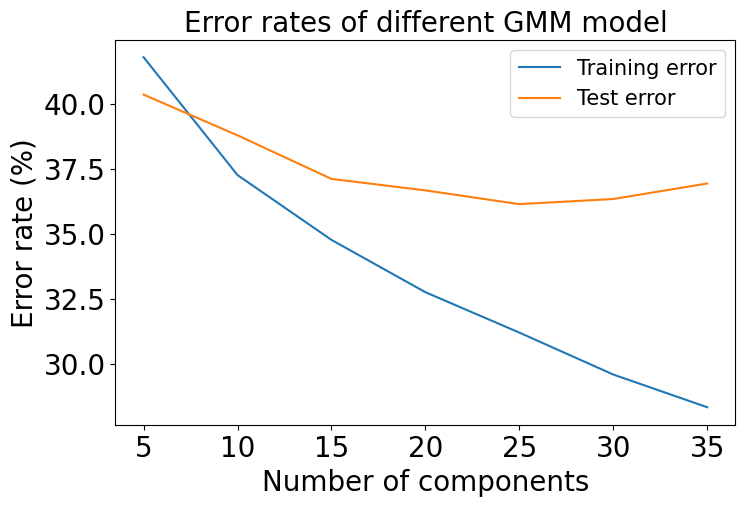

In [64]:
print("n_components = ", n_components_list)
print("train_error_rates = ", [round(i, 2) for i in train_error_rates])
print("test_error_rates = ", [round(i, 2) for i in test_error_rates])
      

plt.figure(figsize=(8, 5))
plt.plot(n_components_list, train_error_rates, label='Training error')
plt.plot(n_components_list, test_error_rates, label='Test error')
plt.title('Error rates of different GMM model', fontsize=20)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Error rate (%)', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=15)

### Question 3:

Using your best model, classify the test data and generate a confusion matrix using the provided function `confusion_matrix`, e.g.:

In [67]:
# Best model is when n_components = 25 (minimum testing data error rate)

S = train_gmm(test_data_normalized, test_class, n_components=25)
predictions = predict(test_data_normalized, S, n_components=25)
C = confusion_matrix(test_class, predictions)

You can visualize the confusion matrix with:

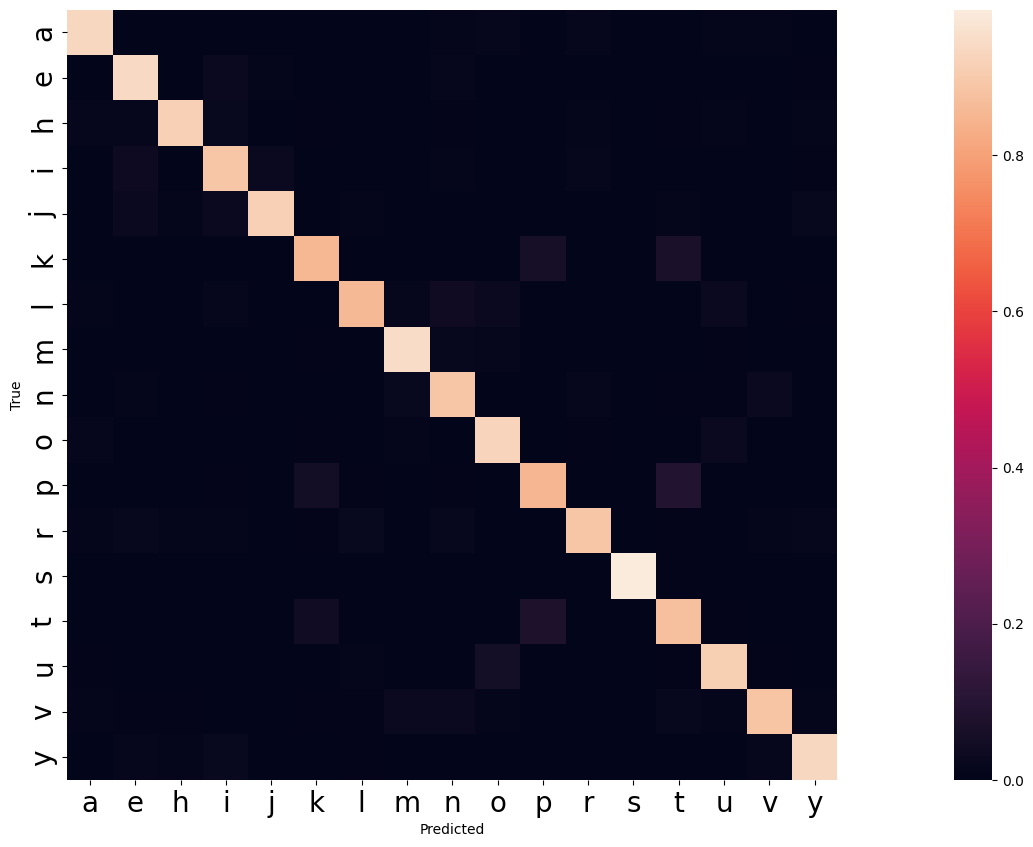

In [68]:
plot_confusion(C, phonemes)

<b>Answer the following questions:</b>

a. Based on the confusion matrix, what can you conclude about phoneme recognition as a task and recognition performance of different phoneme classifiers?

b. Give examples of difficulties this classifier has.

c. Include the (visualized) confusion matrix with the answer.

### Question 4:

Variables `tw1`, `tw2` and `tw3` contain the feature representations of three Finnish words. <b>Classify</b> their features using your best model. 

<b>Answer the following questions:</b>

a. Try to identify the words based on the classification result. (We believe this demonstration works especially well if you <i>don't</i> speak Finnish. Points are rewarded for attempts, not correct answers.)

b. What problems do you see in the frame based classification if one wants to recognize whole words?

c. Describe ideas to improve the results.

In [71]:
# a. Try to identify the words based on the classification result. (We believe this demonstration works especially well if you <i>don't</i> speak Finnish. Points are rewarded for attempts, not correct answers.)

S = train_gmm(test_data_normalized, test_class, n_components=25)
predictions_tw1 = predict(tw1_normalized, S, n_components=25)
predictions_tw2 = predict(tw2_normalized, S, n_components=25)
predictions_tw3 = predict(tw3_normalized, S, n_components=25)

predicted_phonemes_tw1 = [phonemes[x] for x in predictions_tw1]
predicted_phonemes_tw2 = [phonemes[x] for x in predictions_tw2]
predicted_phonemes_tw3 = [phonemes[x] for x in predictions_tw3]

# Joining the predicted phonemes to form a word
predicted_phonemes_tw1_string = ''.join(predicted_phonemes_tw1)
predicted_phonemes_tw2_string = ''.join(predicted_phonemes_tw2)
predicted_phonemes_tw3_string = ''.join(predicted_phonemes_tw3)

print(f"Prediction for tw1 word: {predicted_phonemes_tw1_string}")
print(f"Prediction for tw2 word: {predicted_phonemes_tw2_string}")
print(f"Prediction for tw3 word: {predicted_phonemes_tw3_string}")


Prediction for tw1 word: ptkpkvpkkptttkkkkkkkoooooooooooooooooolllllllllllllaoolmmmmmmmmmlmmrieeerreeey
Prediction for tw2 word: ssssssssssssssssssreeerreeiiireeeeeiiiiiiiiiyiisssssssssssssssssssssttt
Prediction for tw3 word: ehhhhheejeeeeeeeierlllllrrrmmmmmmmmviyiiiktktkkkkuouuuuuuuuuuuuuuuuuoovorssssssssssssssssssssssssavararuaaluvn


## Discriminative models

When we classified feature vectors above, we wanted to pick the most probable phoneme <i>y</i>, given a feature vector <i>x</i>. In other words, we wanted: arg max<sub>y</sub> p(y|x). However, GMMs are a generative model: they learn p(x|y) and p(y). With the Bayes rule, these can be used to find the most probable class by:
<br><br>
<center>arg max<sub>y</sub> p(y|x) = arg max<sub>y</sub> p(x|y)p(y)</center>

We can also construct a model for p(y|x) directly. This type of model is called a discriminative model. Say we want to classify animals as cats or dogs based their silhouettes.

The generative approach is to learn to draw dog silhouettes and cat silhouettes. Look at dogs, make notes about prominent features: four legs, a tail. Look at cats: four legs, a tail. To classify new silhouettes, estimate if you'd be more likely to draw something similar when drawing a cat or a dog.

The discriminative approach is to just look at a bunch of dog and cat pairs and figure out what the differences are. Big whiskers: it's a cat. Large animal: it's a dog. But ask the discriminative model how many legs a dog should have? No idea.

Whether the generative approach or the discriminative approach works better depends on the task. Empirically, in most speech recognition tasks the discriminative approach gives better results.

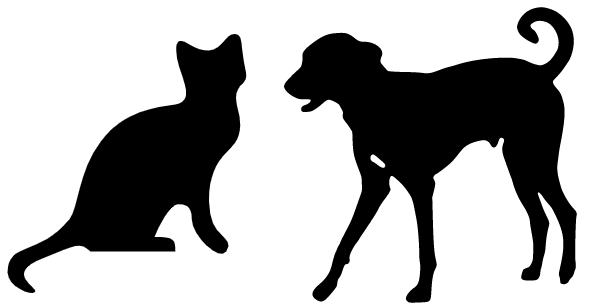

In [23]:
from IPython.display import Image
Image('images/silhouettes.png')

## Deep neural networks

There are many discriminative classifiers, like logistic regression or support vector machines. But Deep neural networks (DNN) classifiers have worked especially well. Since the beginning of the 2010-decade, most machine learning fields, like image classification and speech recognition, attain their state-of-the-art results by applying some type of DNN methods. Nowadays almost all speech recognition systems replace GMMs by DNNs (though GMMs are still used during the iterative process through which the most complex systems are built).

Although this course does not have time to go into the details of DNNs, it would seem strange not to mention them either, since they are now used everywhere. Aalto has a popular course, where you can learn more: [CS-E4890 Deep Learning](https://oodi.aalto.fi/a/opintjakstied.jsp?OpinKohd=1129662615).  For a clear introduction, see [this video series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).

A generative approach actually assumes a model of how the data is generated. Discriminatively trained DNNs learn distinguishing factors directly from the data. In fact they are especially good at this. Many aspects of MFCCs have been manually engineered to work with GMMs' assumptions; with DNNs some of the feature extraction steps can be skipped, and the classifier learns more powerful representations in a data-driven way.

Now we will try a Multi Layer Perceptron (MLP, a basic type of DNN) classifier for our phoneme recognition task.

In [72]:
from sklearn.neural_network import MLPClassifier

In [73]:
num_hidden_layers = 3
layer_size = 300
num_classes = len(np.unique(train_class))

In [74]:
neural_network = MLPClassifier(hidden_layer_sizes=(layer_size, layer_size),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    alpha=1e-4,
                    max_iter=15,
                    random_state=0)

neural_network.fit(train_data_normalized, train_class)

c:\Users\springnuance\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(300, 300), max_iter=15, random_state=0)

In [27]:
predictions = neural_network.predict(test_data_normalized)

In [28]:
print(accuracy_score(predictions, test_class) * 100)

68.1466755025403


In [29]:
total_parameters = (26 * layer_size + layer_size * layer_size + layer_size * layer_size + layer_size * num_classes) + num_hidden_layers * layer_size + num_classes
print('The total number of parameters in the MLP model is: {0}'.format(total_parameters))

The total number of parameters in the MLP model is: 193817


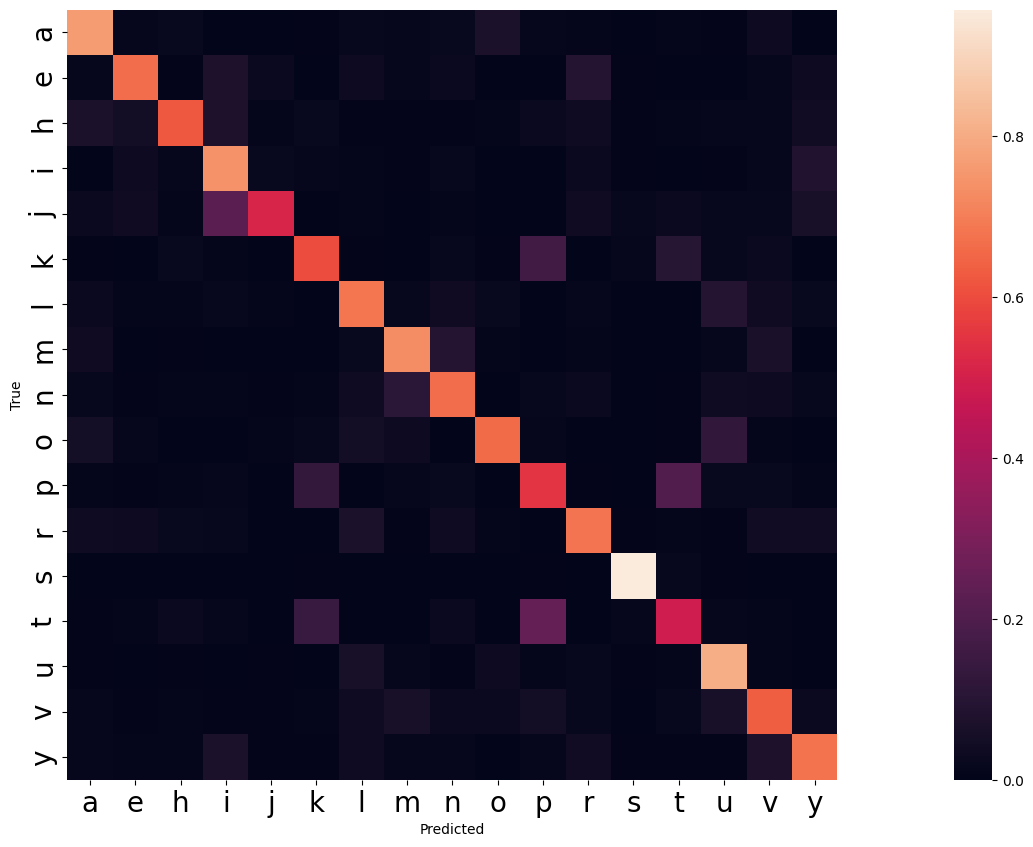

In [30]:
C = confusion_matrix(test_class, predictions)
plot_confusion(C, phonemes)

### Question 5:

DNNs can leverage large datasets, but here we have quite a small training set.

a. Which model performs classification better, the DNN or your best GMM?

b. The number of trained parameters in the DNN is reported above. Now look inside your best GMM model, the dictionary returned by `train_gmm`. Note: strictly speaking, there is a separate GMM for each class (phoneme), so count the total number of parameters for all the classes altogether. How many trained (estimated) parameters does your best GMM have (Remember: we used diagonal-covariance matrix GMMs)? Which model type used more parameters?

In [78]:
print(S.keys())
mu = S['mu']
sigma = S['sigma']
prior = S['prior']
weight = S['weight']
model = S['model']

print("mu.shape: ", mu.shape)
print("sigma.shape: ", sigma.shape)
print("prior.shape: ", np.array(prior).shape)
print("weight.shape: ", weight.shape)
print("model.shape: ", len(model))

dict_keys(['mu', 'sigma', 'prior', 'weight', 'model'])
mu.shape:  (17, 25, 26)
sigma.shape:  (17, 25, 26)
prior.shape:  (17,)
weight.shape:  (17, 25)
model.shape:  17


## Sampling

Since the GMM is a generative model, we can sample some MFCCs from it. Sample 100 MFCCs from each phoneme class by running:

In [31]:
def sample(gmm_models, sampled_class):
    sampled_data = []
    for cls in sampled_class:
        gmm_model = gmm_models[cls]
        sampled_data.append(gmm_model.sample(1)[0])
    return np.array(sampled_data).squeeze()

In [32]:
sampled_class = np.arange(0, 17, 1).repeat(100)
gmm_models = S['model']
sampled_data = sample(gmm_models, sampled_class)

Notice that sampled_class has the reference `class numbers`.

Now classify the sampled MFCCs with the GMM model, just like you did with `train_data` and `test_data`. Then classify them with the DNN.

In [33]:
# GMM predict
predictions = predict(sampled_data, S, n_components)
print(accuracy_score(predictions, sampled_class) * 100)

70.58823529411765


In [34]:
# DNN predict
sampled_data_normalized = z.transform(sampled_data)
predictions = neural_network.predict(sampled_data_normalized)
print(accuracy_score(predictions, sampled_class) * 100)

47.05882352941176


### Question 6:

a. Which model has lower classification error on the sampled MFCCs? Why might that be?